**Imports**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

**Load Data**

In [3]:
file_path = "../data/Red Bull Case Study Data.xlsx"

df = pd.read_excel(file_path, engine="openpyxl")

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5976 entries, 0 to 5975
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Calendar Day         5976 non-null   datetime64[us]
 1   H4 Prd Variant       5976 non-null   str           
 2   H5 Prd Filling size  5976 non-null   str           
 3   H7 Prd Pckg Unit     5976 non-null   str           
 4   Customer A           5777 non-null   float64       
 5   Customer B           3442 non-null   float64       
 6   Customer C           756 non-null    float64       
dtypes: datetime64[us](1), float64(3), str(3)
memory usage: 326.9 KB


Correct misspelling "Red Bull Watermlon Edition" -> "Red Bull Watermelon Edition", exclude dates prior to 2018

In [5]:
df["H4 Prd Variant"] = df["H4 Prd Variant"].replace(
    "Red Bull Watermlon Edition",
    "Red Bull Watermelon Edition"
)
df = df[df["Calendar Day"].dt.year >= 2018]

**Reshape Data**

Add Customer Total

In [6]:
customer_cols = ["Customer A", "Customer B", "Customer C"]
df["Customer Total"] = df[customer_cols].sum(axis=1, skipna=True)

# If ALL customers are NaN → set total to NaN
all_nan_mask = df[customer_cols].isna().all(axis=1)
df.loc[all_nan_mask, "Customer Total"] = pd.NA

Reshape

In [ ]:
df["product_id"] = (
    df["H4 Prd Variant"] + " | "
    + df["H5 Prd Filling size"] + " | "
    + df["H7 Prd Pckg Unit"]
)
df=df.drop(columns=['H4 Prd Variant','H5 Prd Filling size','H7 Prd Pckg Unit'])

df = df.melt(
    id_vars=["Calendar Day", "product_id"],
    #value_vars=["Customer A", "Customer B", "Customer C","Customer Total"],
    value_vars=["Customer Total"],
    var_name="customer",
    value_name="demand"
)

In [8]:
df.head()

,Calendar Day,product_id,customer,demand
0,2018-01-03,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,4074.0
1,2018-01-03,Red Bull Energy Drink | 250ml/8.4oz | 4Pack,Customer A,56678.0
2,2018-01-03,Red Bull Energy Drink | 250ml/8.4oz | Single,Customer A,211289.0
3,2018-01-03,Red Bull Energy Drink | 355ml/12oz | Single,Customer A,277332.0
4,2018-01-04,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,7291.0


**Plots**

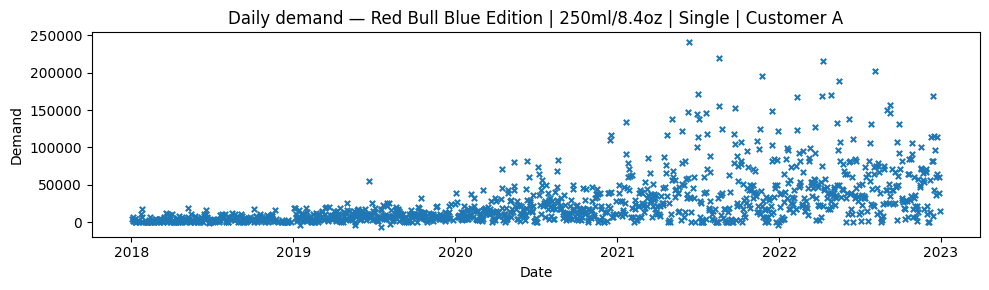

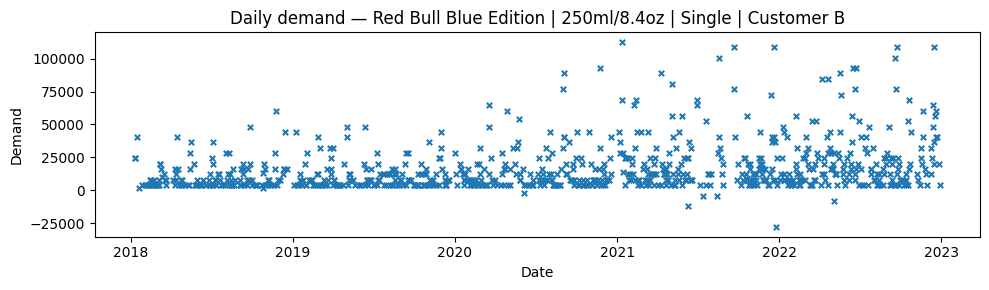

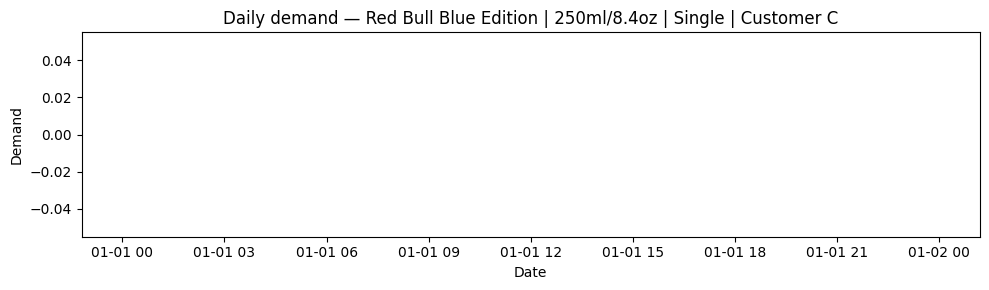

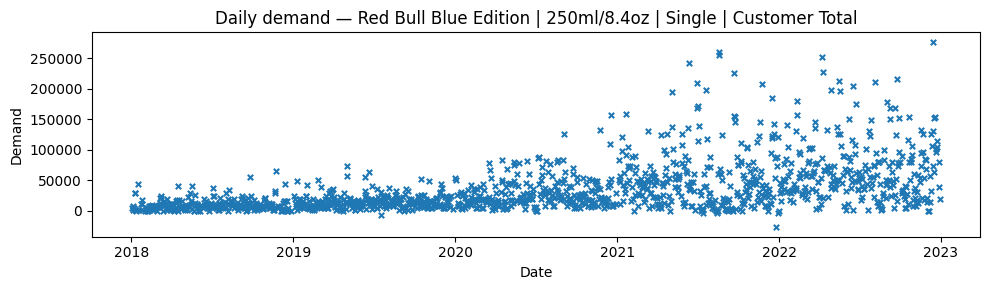

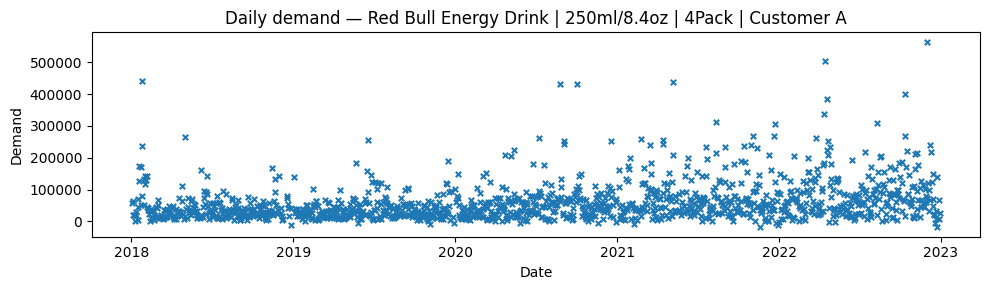

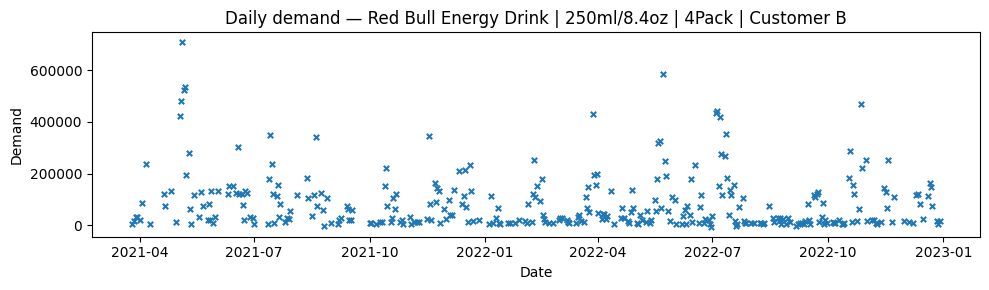

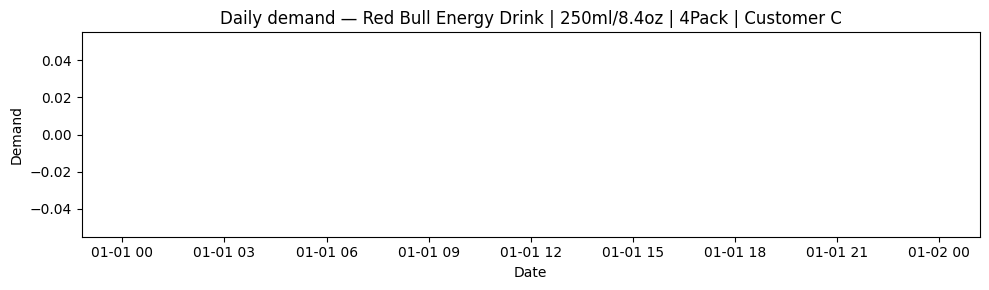

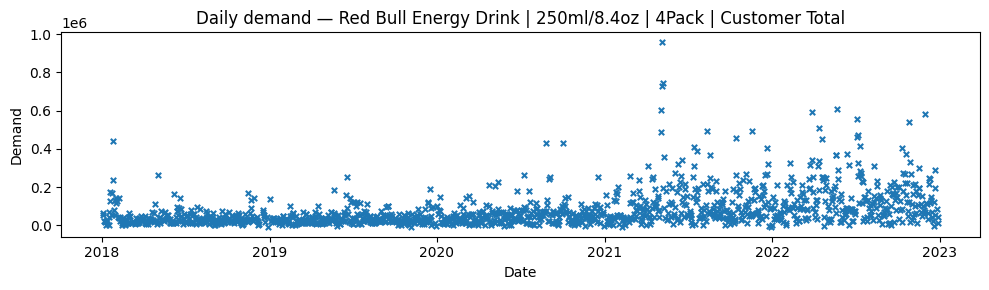

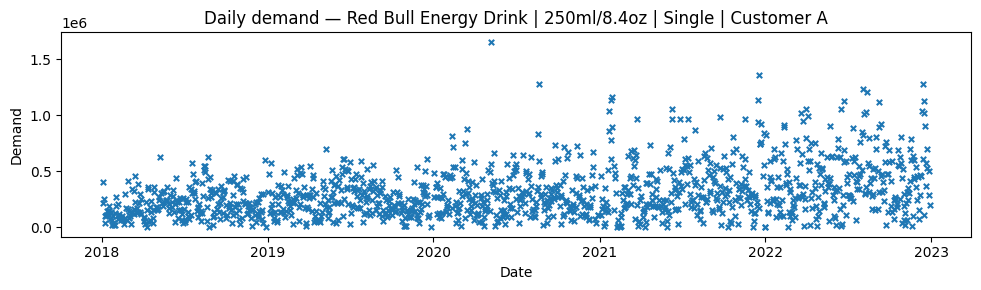

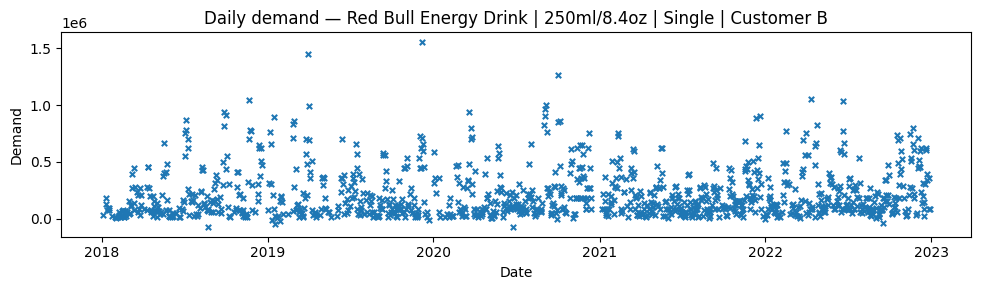

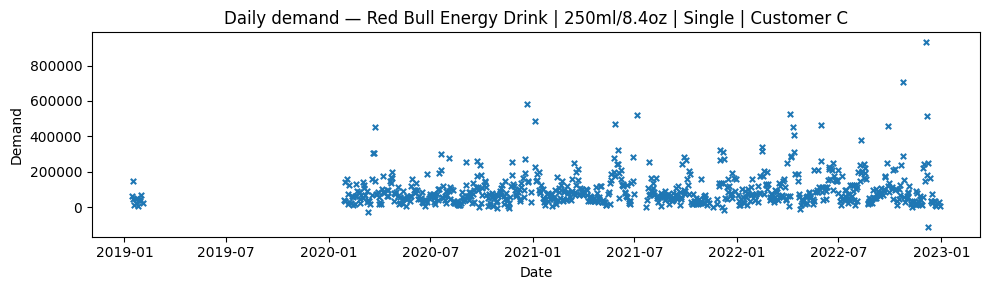

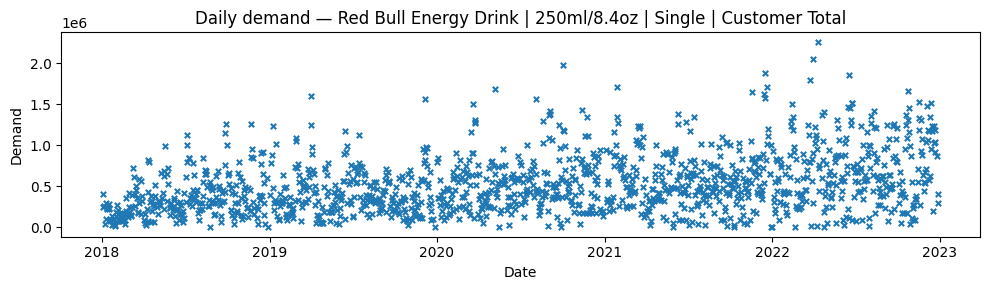

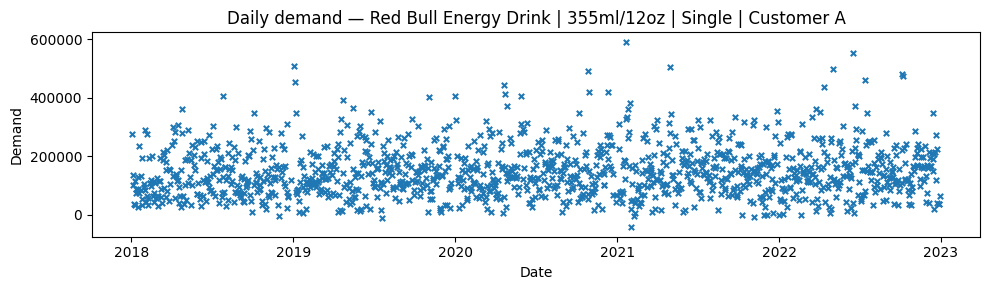

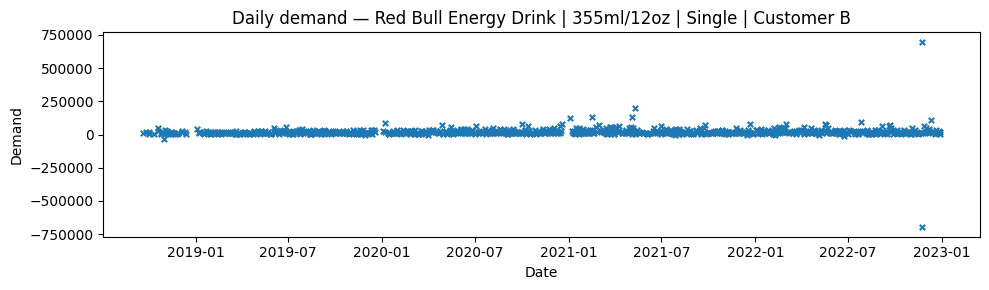

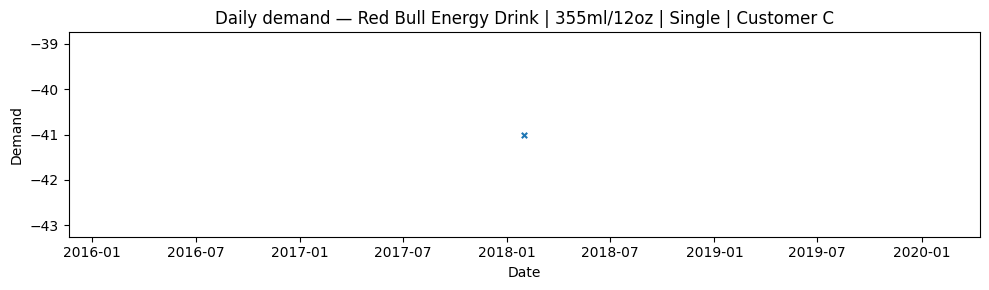

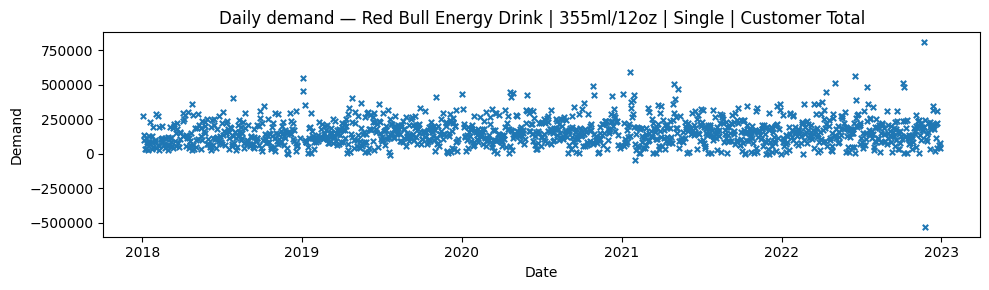

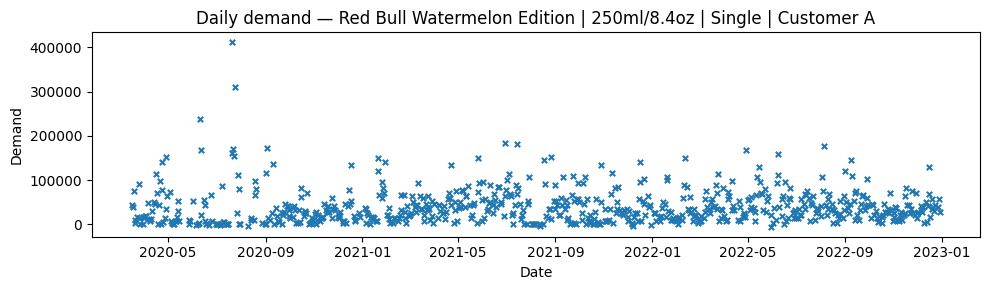

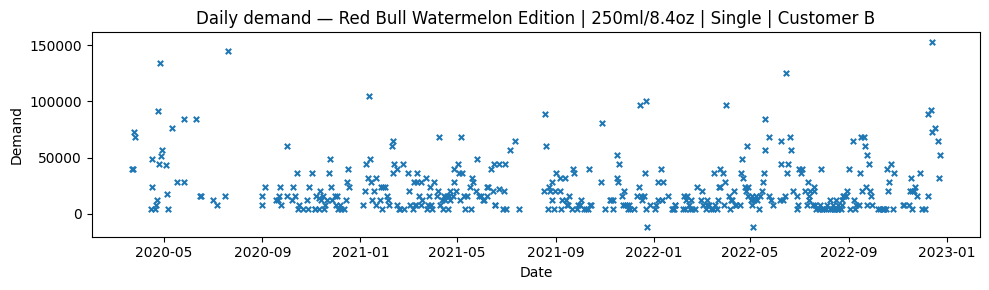

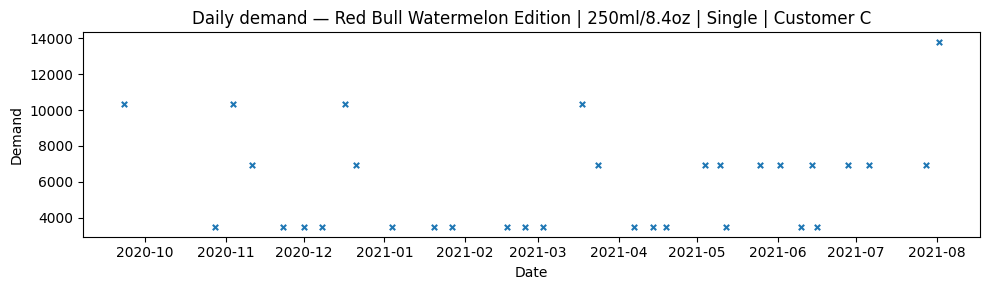

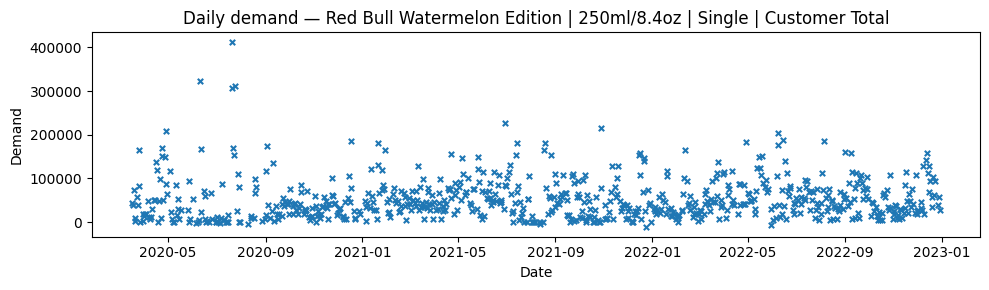

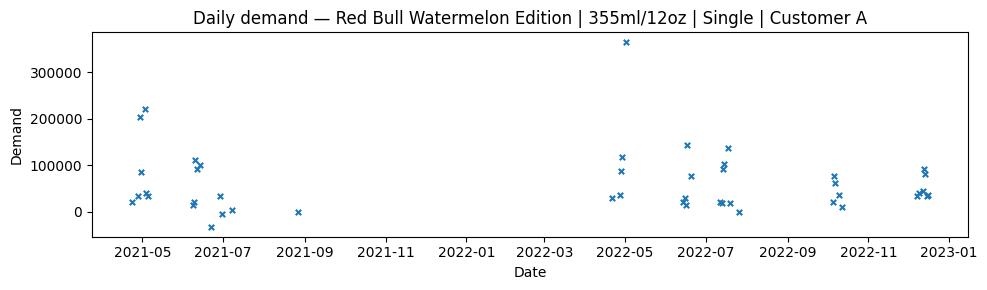

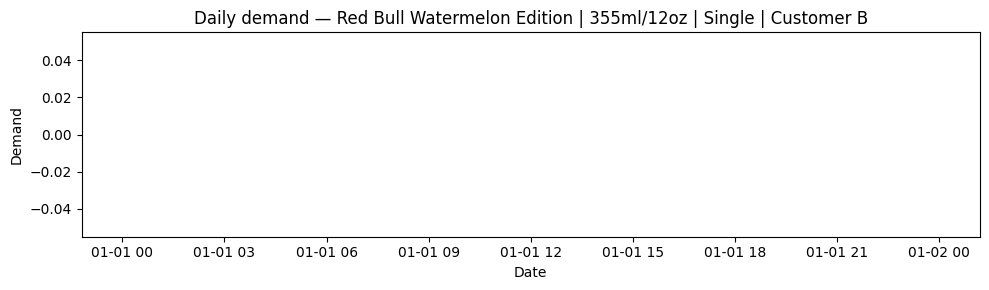

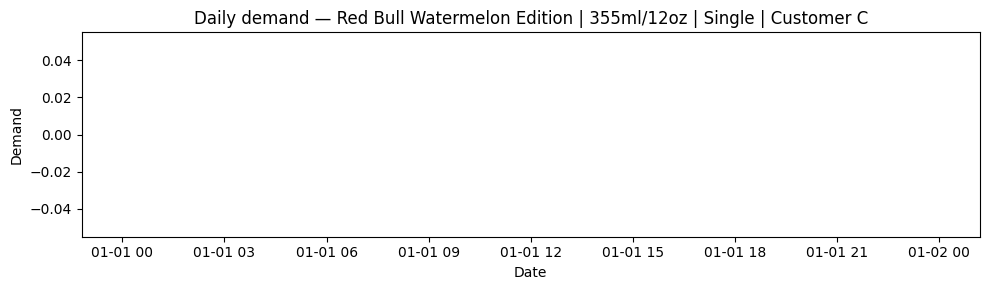

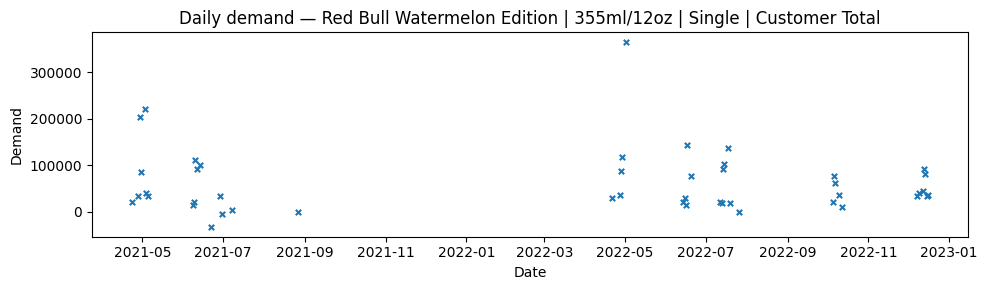

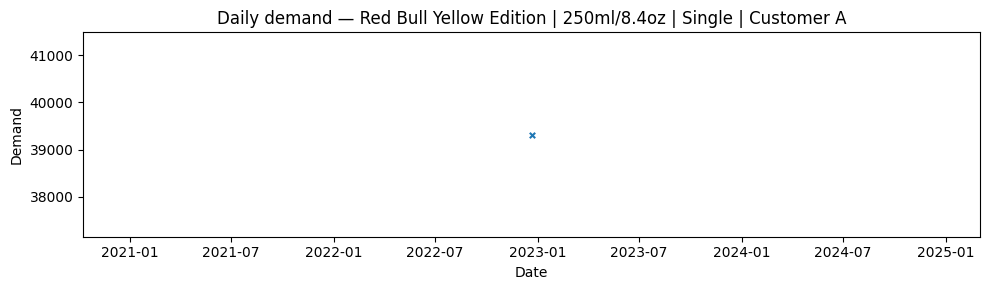

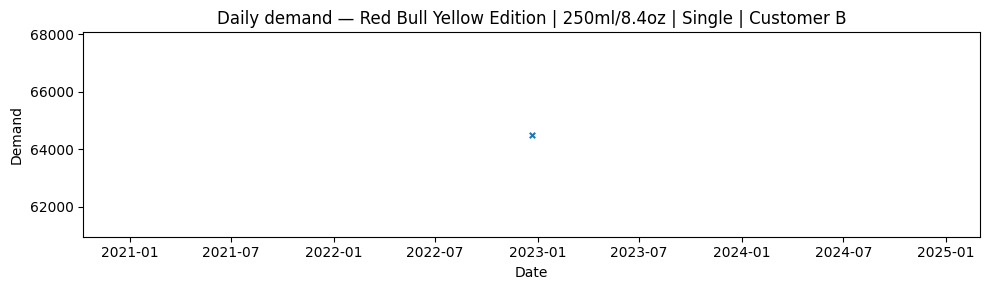

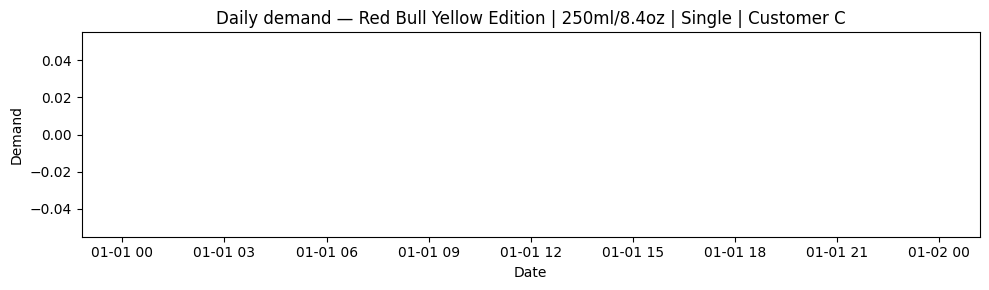

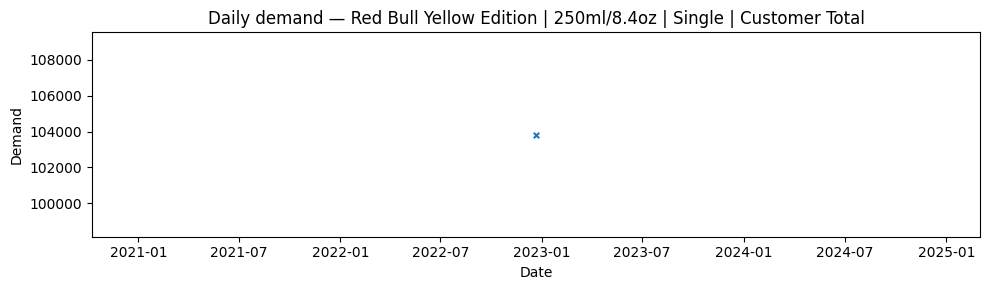

In [9]:
df = df.sort_values("Calendar Day")

groups = df.groupby(["product_id", "customer"])

for (product, customer), g in groups:
    
    g = g.sort_values("Calendar Day")
    
    # Drop NaNs so nothing is plotted for them
    g_non_null = g.dropna(subset=["demand"])
    
    plt.figure(figsize=(10, 3))
    
    plt.scatter(
        g_non_null["Calendar Day"],
        g_non_null["demand"],
        marker="x",
        s=15  # size of the x marker
    )
    
    plt.title(f"Daily demand — {product} | {customer}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    
    plt.tight_layout()
    plt.show()


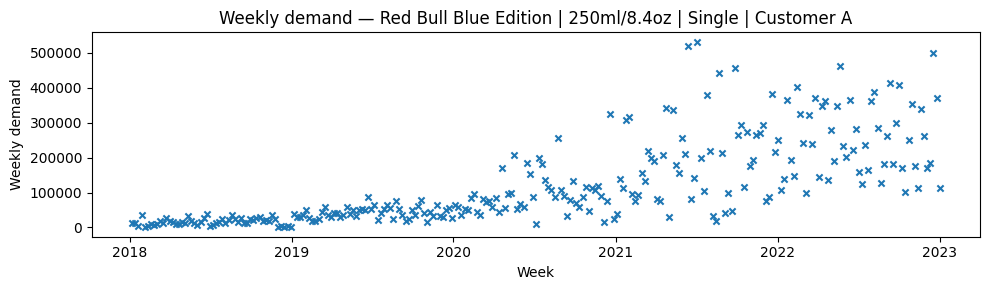

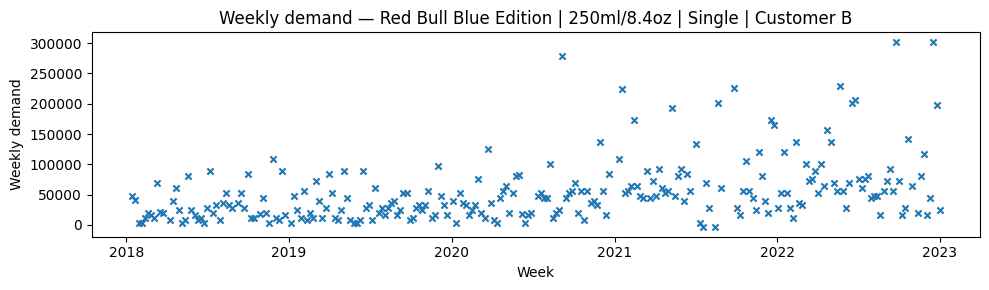

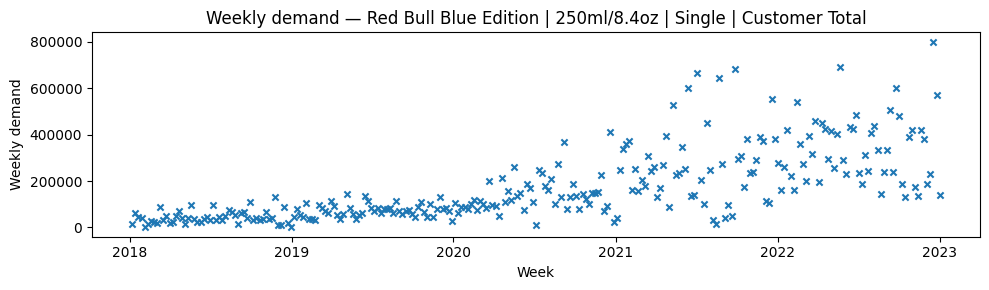

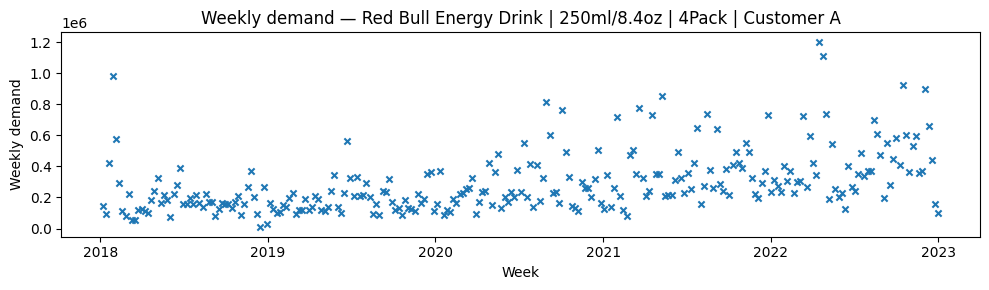

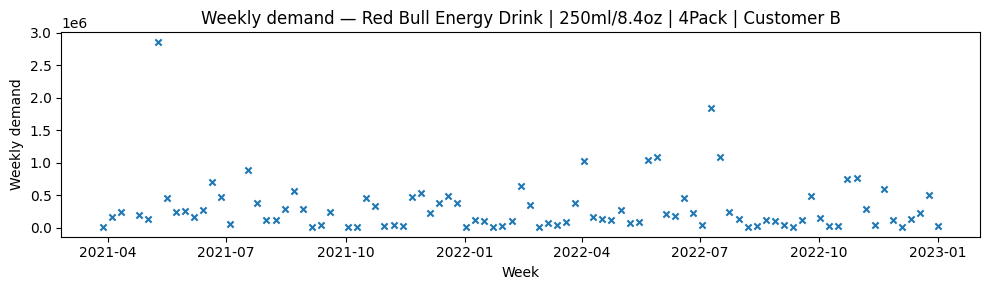

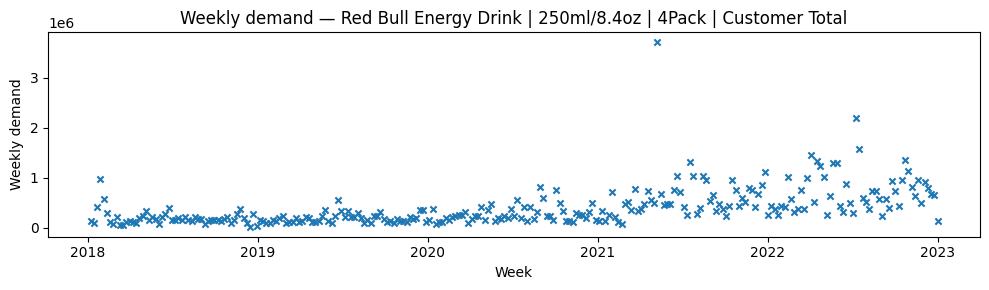

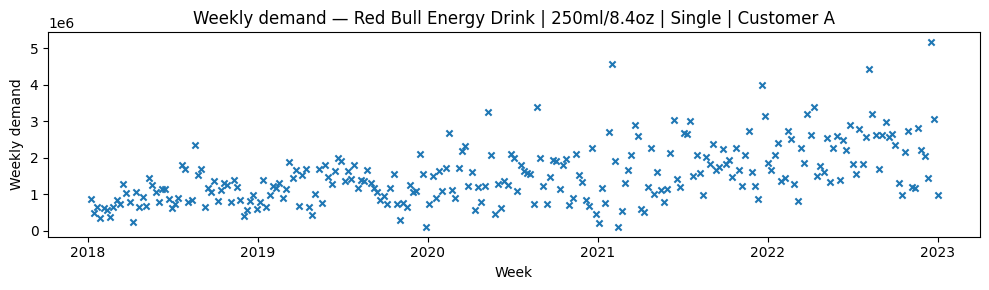

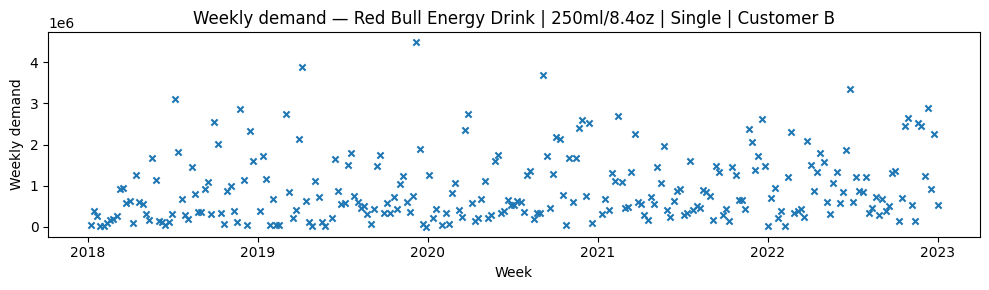

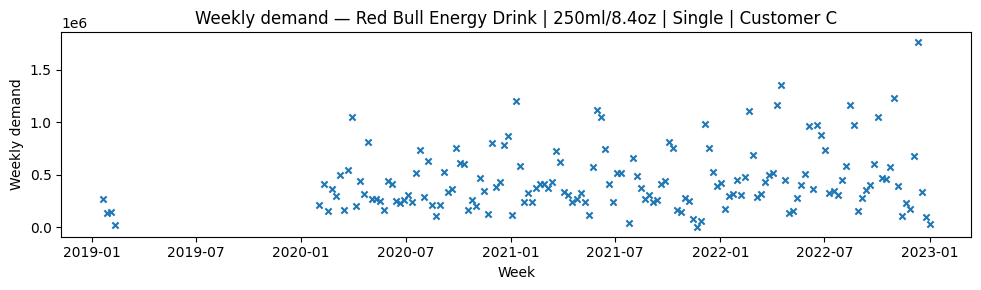

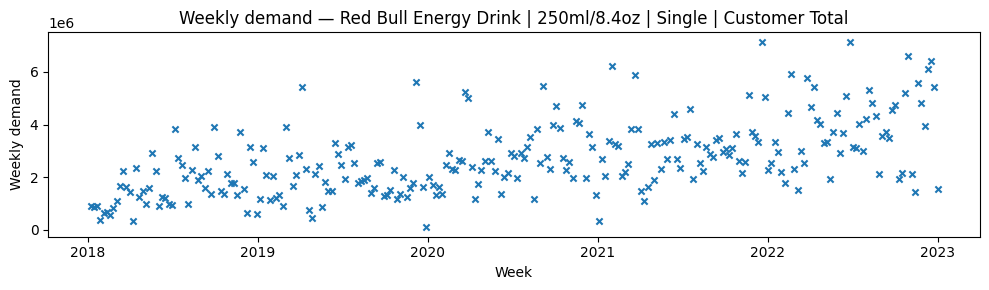

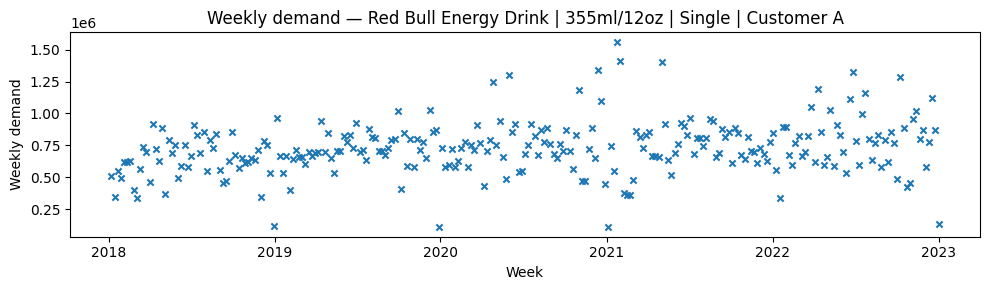

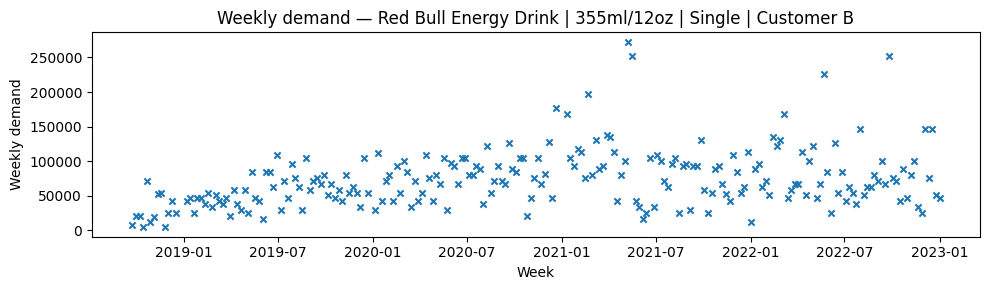

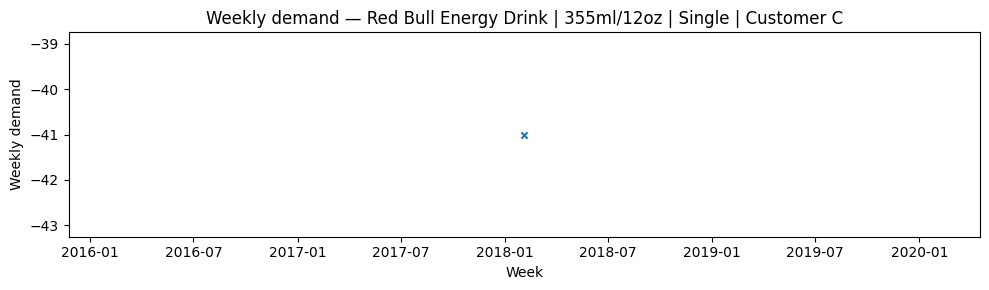

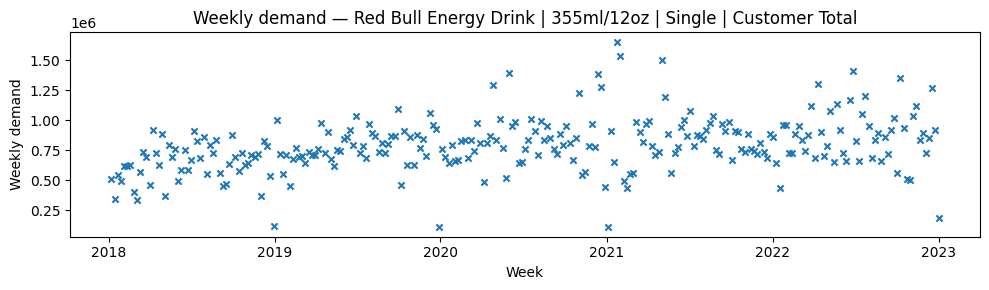

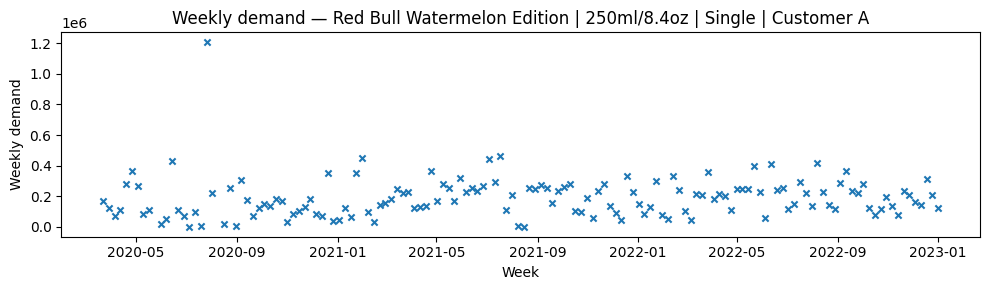

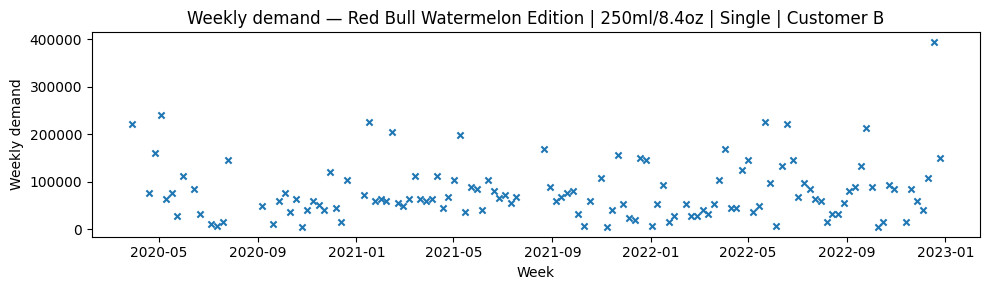

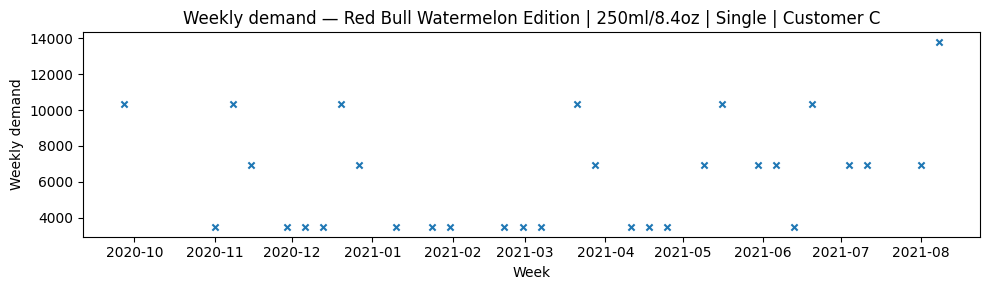

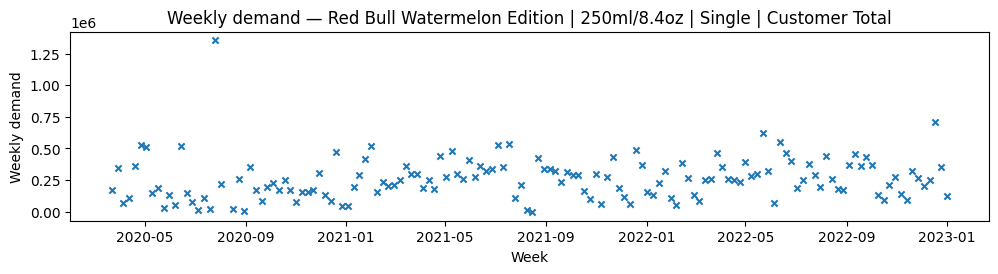

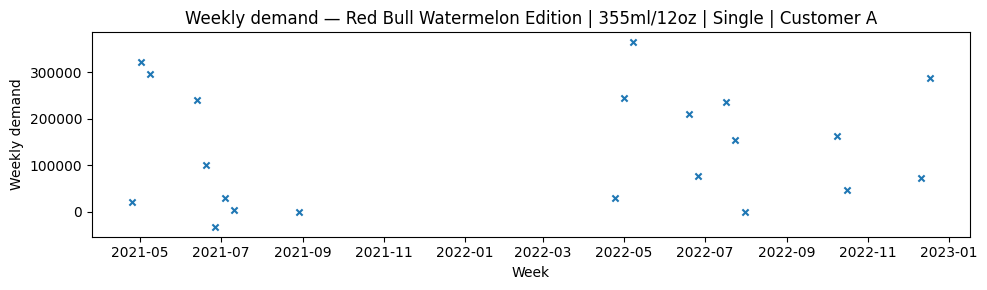

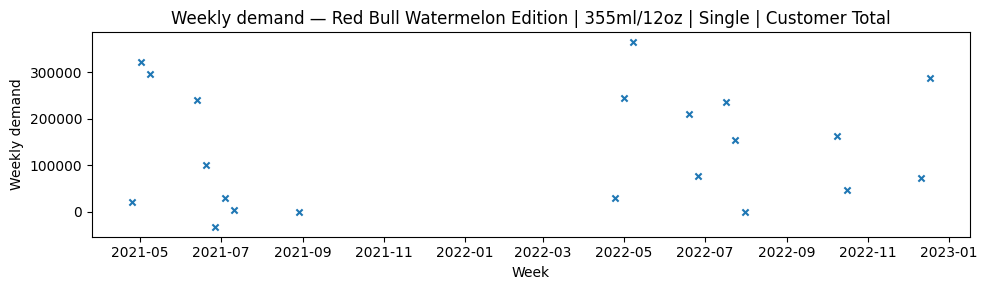

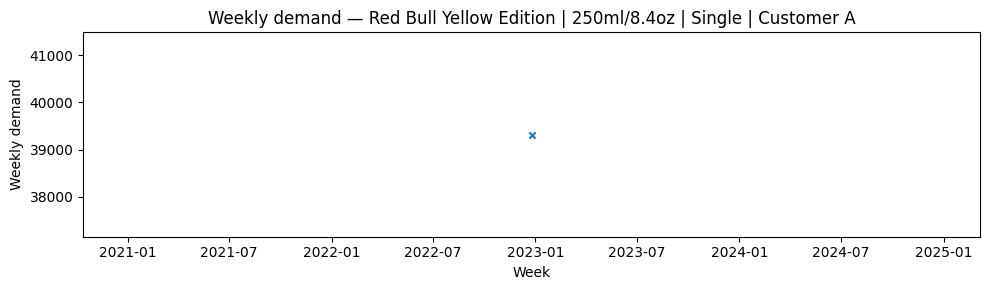

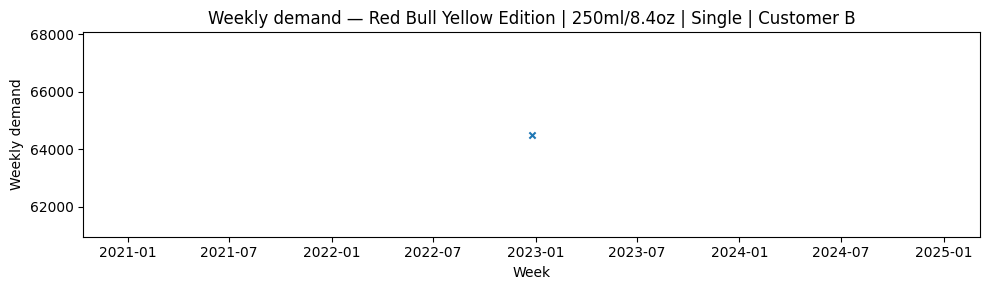

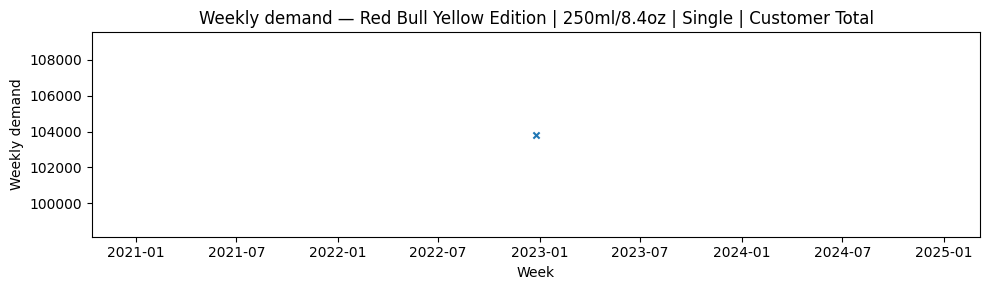

In [10]:
df_weekly = (
    df
    .set_index("Calendar Day")
    .groupby(["product_id", "customer"])
    .resample("W")["demand"]
    .sum(min_count=1)   # <-- crucial
    .reset_index()
)

groups = df_weekly.groupby(["product_id", "customer"])

for (product, customer), g in groups:
    
    g_non_null = g.dropna(subset=["demand"])
    
    if g_non_null.empty:
        continue
    
    plt.figure(figsize=(10, 3))
    
    plt.scatter(
        g_non_null["Calendar Day"],
        g_non_null["demand"],
        marker="x",
        s=20
    )
    
    plt.title(f"Weekly demand — {product} | {customer}")
    plt.xlabel("Week")
    plt.ylabel("Weekly demand")
    
    plt.tight_layout()
    plt.show()

In [11]:
def plot_weekly_deviation_with_histograms(df_weekly, product_x, product_y, customer="Customer Total"):
    """
    Scatter plot of deviations between two products, with Pearson & Spearman correlations,
    and histograms of the marginal distributions of deviations.
    """
    # Filter for customer and drop NaNs
    df_filtered = df_weekly[df_weekly['customer'] == customer].copy()
    df_filtered = df_filtered.dropna(subset=['demand'])
    
    # Pivot to wide format
    df_wide = df_filtered.pivot_table(
        index='Calendar Day',
        columns='product_id',
        values='demand'
    )[[product_x, product_y]].dropna()
    
    # Compute quadratic deviation
    def quadratic_dev(series):
        t = np.arange(len(series))
        coeffs = np.polyfit(t, series, deg=2)
        trend = np.polyval(coeffs, t)
        return series - trend
    
    df_wide['dev_x'] = quadratic_dev(df_wide[product_x])
    df_wide['dev_y'] = quadratic_dev(df_wide[product_y])
    
    # Compute correlations
    pearson_r, pearson_p = pearsonr(df_wide['dev_x'], df_wide['dev_y'])
    spearman_rho, spearman_p = spearmanr(df_wide['dev_x'], df_wide['dev_y'])
    
    # Setup figure with scatter + histograms
    fig = plt.figure(figsize=(8,8))
    
    # Define grids
    grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)
    
    ax_main = fig.add_subplot(grid[1:4, 0:3])
    ax_xhist = fig.add_subplot(grid[0, 0:3], sharex=ax_main)
    ax_yhist = fig.add_subplot(grid[1:4, 3], sharey=ax_main)
    
    # Scatter plot
    ax_main.scatter(df_wide['dev_x'], df_wide['dev_y'], alpha=0.6)
    ax_main.set_xlabel(f"{product_x} deviation")
    ax_main.set_ylabel(f"{product_y} deviation")
    ax_main.grid(True)
    
    # Add correlation text
    textstr = (
        f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3f})\n"
        f"Spearman ρ = {spearman_rho:.2f} (p = {spearman_p:.3f})"
    )
    ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes,
                 fontsize=10, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.5))
    
    # Histograms
    ax_xhist.hist(df_wide['dev_x'], bins=20, color='skyblue', edgecolor='k')
    ax_xhist.set_ylabel('Count')
    ax_xhist.grid(True)
    
    ax_yhist.hist(df_wide['dev_y'], bins=20, orientation='horizontal', color='salmon', edgecolor='k')
    ax_yhist.set_xlabel('Count')
    ax_yhist.grid(True)
    
    # Hide x labels for xhist and y labels for yhist
    plt.setp(ax_xhist.get_xticklabels(), visible=False)
    plt.setp(ax_yhist.get_yticklabels(), visible=False)
    
    plt.show()


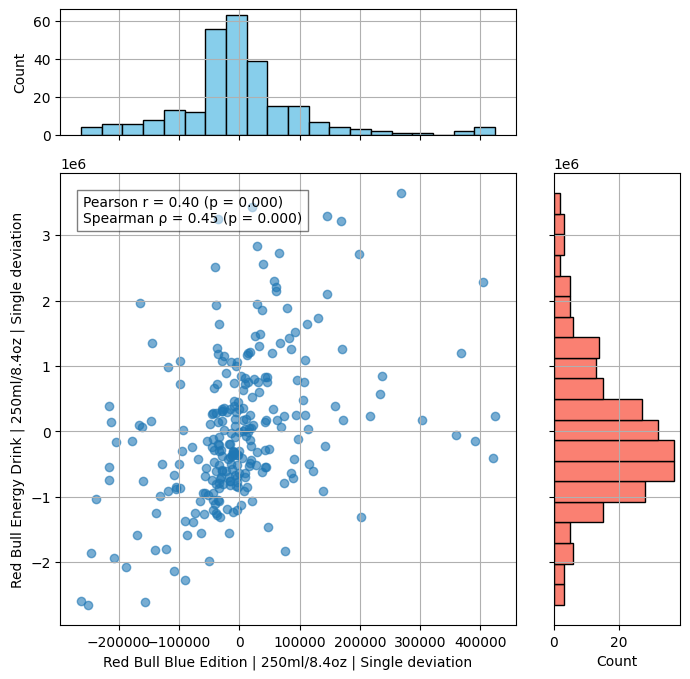

In [12]:
plot_weekly_deviation_with_histograms(
    df_weekly, 
    product_x="Red Bull Blue Edition | 250ml/8.4oz | Single", 
    product_y="Red Bull Energy Drink | 250ml/8.4oz | Single"
)